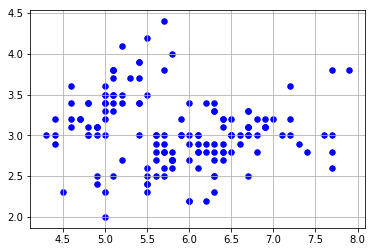

In [78]:
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt


'''X, y = make_blobs(n_samples=150,
                 n_features=2,
                 centers=4,
                 cluster_std=0.5,
                 shuffle=True,
                 random_state=0)
'''
X = load_iris()
X = X.data[:,:2]
plt.scatter(X[:,0],
           X[:,1],
            c='blue',
           marker='o',
           s=30)
plt.grid()
plt.show()

In [51]:
def plot_decisions(X, dec, n_clust=0, leg=True):
    assert n_clust >= 0
    if n_clust == 0:
        n_clust = len(np.unique(dec))
    for i in range(1,n_clust+1):
        plt.scatter(X[dec==i,0],
                   X[dec==i,1],
                   s=40,
                   c=rand.rand(1,4)[0],
                   marker='^',
                   label=('cluster ' + str(i)))
    if leg:
        plt.legend()
    plt.grid()
    plt.show()

In [52]:
import numpy as np


def euclidean_dist_sq(point1, point2):
    assert len(point1) == len(point2)
    result = 0
    for i in range(len(point1)):
        result = result + (point1[i]-point2[i])**2
    return result

def minkovski_dist(point1, point2, p=2):
    assert len(point1) == len(point2)
    result = 0
    for i in range(len(point1)):
        result = result + (point1[i]-point2[i])**p
    return result**(1/p)

def taxicab_dist(point1, point2):
    assert len(point1) == len(point2)
    result = 0
    for i in range(len(point1)):
        result = result + abs(point1[i]-point2[i])
    return result

def chebyshev_dist(point1, point2):
    assert len(point1) == len(point2)
    result = 0
    for i in range(len(point1)):
        val = abs(point1[i]-point2[i])
        if val > result:
            result = val 
    return result

def calculate_dist(data, how='euclid'):
    n = len(data)
    result = np.zeros((n,n),dtype=np.float32)
    for i in range(n):
        for j in range(n):
            if how == 'euclid':
                result[i,j] = euclidean_dist_sq(data[i],data[j])
            elif how == 'minkowski':
                result[i,j] = minkovski_dist(data[i],data[j], p=2)
            elif how == 'taxicab':
                result[i,j] = taxicab_dist(data[i],data[j])
            elif how == 'chebyshev':
                result[i,j] = chebyshev_dist(data[i],data[j])
    return result

# Crab

In [53]:
class Graph():
    def __init__(self, vertices):
        self.V = vertices
        # Create distance matrix for graph
        self.graph = [[0 for column in range(vertices)] 
                      for row in range(vertices)]
        self.maxint = 999999999
    
    # Create adjacency matrix for MST
    def createMST_matrix(self, parent):
        result = np.zeros((len(parent),len(parent)),dtype=np.float)
        for i in range(len(parent)):
            result[i,parent[i]] = self.graph[i,parent[i]]
            result[parent[i],i] = self.graph[i,parent[i]]
        return result
 
    # A utility function to find the vertex with minimum distance value, from
    # the set of vertices not yet included in shortest path tree
    def minKey(self, key, mstSet):
        # Initilaize min value
        mn = self.maxint
        for v in range(self.V):
            if key[v] < mn and mstSet[v] == False:
                mn = key[v]
                min_index = v
        return min_index
 
    # Function to construct MST for a graph using adjacency matrix representation
    def primMST(self):
        #Key values used to pick minimum weight edge in cut
        key = [self.maxint] * self.V
        parent = [None] * self.V
        key[0] = 0   # Make key 0 so that this vertex is picked as first vertex
        mstSet = [False] * self.V
        parent[0] = -1  # Mark first node as the root
 
        for cout in range(self.V):
            # Pick the minimum distance vertex from the set of vertices not
            # yet processed. u is always equal to src in first iteration
            u = self.minKey(key, mstSet)
            # Put the minimum distance vertex in the shortest path tree
            mstSet[u] = True
            # Update dist value of the adjacent vertices of the picked vertex
            # only if the current distance is greater than new distance and
            # the vertex in not in the shortest path tree
            for v in range(self.V):
                # graph[u][v] is non zero only for adjacent vertices of m
                # mstSet[v] is false for vertices not yet included in MST
                # Update the key only if graph[u][v] is smaller than key[v]
                if self.graph[u][v] > 0 and mstSet[v] == False and key[v] > self.graph[u][v]:
                    key[v] = self.graph[u][v]
                    parent[v] = u
 
        res = self.createMST_matrix(parent)
        return res

In [79]:
import numpy as np
import numpy.random as rand

class Crab(object):
    def __init__(self, dist_matrix):
        self.dist_matrix = dist_matrix
        
    def fit(self, data):
        self.data = data
        self.n_obj = len(data)
       
    def get_random_el(self, classes):
        # Make sure that the point is not in class already 
        while(True):
            index = rand.randint(0, len(classes))
            if classes[index] == 0:
                return index  
    
    def predict(self, n_clust):
        # Firts stage: building MST
        g = Graph(len(self.dist_matrix))
        g.graph = self.dist_matrix
        mst = g.primMST()
        
        # Second stage
        # Find n_clust - 1 max edges
        while(n_clust > 0):
            # Find longest edge in MST and cut them off
            i,j = np.unravel_index(mst.argmax(), mst.shape)
            mst[i,j] = 0
            mst[j,i] = 0
            n_clust -= 1
        
        # Make dfs on MST
        result = np.zeros(len(mst), dtype=np.int)
        class_n = 1
        while(not all(el > 0 for el in result)):
            candid = list()
            point = self.get_random_el(result)
            candid.append(point)
            result[point] = class_n            
            while(len(candid) > 0):
                # Get next point from stack and find 
                p = candid.pop()
                for i in range(len(result)):
                    if (result[i] == 0) and (mst[p,i] > 0) and (i not in candid):
                        # Find all neighbour points that are not far than e from starting point
                        # Append such point to stack
                        candid.append(i)
                        result[i] = class_n
            # If all elements classified, move to next class
            class_n += 1
        return result

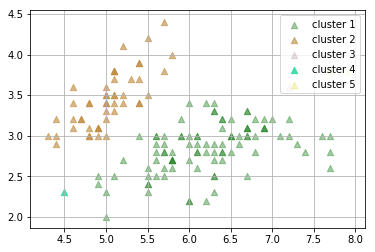

In [100]:
crab = Crab(d_m)
crab.fit(X)
crab_pred = crab.predict(n_clust=5)
plot_decisions(X, crab_pred, leg=True)

# Spectre

In [56]:
import numpy as np
import numpy.random as rand


class Spectre(object):
    def __init__(self, dist_matrix):
        self.dist_matrix = dist_matrix
        
    def fit(self, data):
        self.data = data
        self.n_obj = len(data)
        
    def calc_con(self, x_index, elems_index):
        m = len(elems_index)
        buffer = 0
        for i in elems_index:
            buffer += self.dist_matrix[i,x_index]
        return buffer/m
    
    def get_random_center(self, classes):
        # Make sure that the point is not in class already 
        while(True):
            index = rand.randint(0, self.n_obj)
            if classes[index] == 0:
                return index

    def predict(self, e=1.0):
        result = np.zeros(self.n_obj, dtype=np.int)
        class_n = 1
        while(not all(el > 0 for el in result)):
            rand_i = self.get_random_center(result)
            b = [rand_i]
            while(True):
                max_dist = -1000000
                max_idx = 0
                for el in range(self.n_obj):
                    dist = self.calc_con(el, b)
                    # Find minimal distance and assert that element is not in class and not in B
                    if dist > max_dist and result[el] == 0: #and el not in b:
                        max_dist = dist
                        max_idx = el
                # Break if next element is alrady in B or distance is over e
                if max_idx in b or max_dist > e:
                    result[b] = class_n
                    class_n += 1
                    break
                else:
                    b.append(max_idx)
        return result

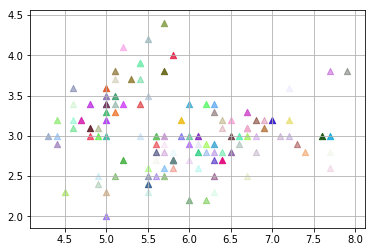

In [101]:
d_m = calculate_dist(X)
spectre = Spectre(d_m)
spectre.fit(X)
sp_pred = spectre.predict(e=0.5)
plot_decisions(X, sp_pred, leg=False)

# Prim's

In [58]:
class Prim():
    def __init__(self, vertices):
        self.V = vertices
        # Create distance matrix for graph
        self.graph = [[0 for column in range(vertices)] 
                      for row in range(vertices)]
        self.maxint = 999999999
    
    def fit(self, data):
        self.data = data
        self.n_obj = len(data)
        
    # Create adjacency matrix for MST
    def createMST_matrix(self, parent):
        result = np.zeros((len(parent),len(parent)),dtype=np.float)
        for i in range(len(parent)):
            result[i,parent[i]] = self.graph[i,parent[i]]
            result[parent[i],i] = self.graph[i,parent[i]]
        return result
 
    # A utility function to find the vertex with minimum distance value, from
    # the set of vertices not yet included in shortest path tree
    def minKey(self, key, mstSet):
        # Initilaize min value
        mn = self.maxint
        for v in range(self.V):
            if key[v] < mn and mstSet[v] == False:
                mn = key[v]
                min_index = v
        return min_index
     
    def get_random_el(self, classes):
        # Make sure that the point is not in class already 
        while(True):
            index = rand.randint(0, len(classes))
            if classes[index] == 0:
                return index    
    
    # Function to construct MST for a graph using adjacency matrix representation
    def predict(self, e=1.0):
        #Key values used to pick minimum weight edge in cut
        key = [self.maxint] * self.V
        parent = [None] * self.V
        key[0] = 0   # Make key 0 so that this vertex is picked as first vertex
        mstSet = [False] * self.V
        parent[0] = -1  # Mark first node as the root
 
        for cout in range(self.V):
            # Pick the minimum distance vertex from the set of vertices not
            # yet processed. u is always equal to src in first iteration
            u = self.minKey(key, mstSet)
            # Put the minimum distance vertex in the shortest path tree
            mstSet[u] = True
            # Update dist value of the adjacent vertices of the picked vertex
            # only if the current distance is greater than new distance and
            # the vertex in not in the shortest path tree
            for v in range(self.V):
                # graph[u][v] is non zero only for adjacent vertices of m
                # mstSet[v] is false for vertices not yet included in MST
                # Update the key only if graph[u][v] is smaller than key[v]
                if self.graph[u][v] > 0 and mstSet[v] == False and key[v] > self.graph[u][v]:
                    key[v] = self.graph[u][v]
                    parent[v] = u
                    
        
        mst = self.createMST_matrix(parent)
        result = np.zeros(len(mst), dtype=np.int)
        class_n = 1
        
        # Find clusters by preparing dfs on minimal spanning tree
        while(not all(el > 0 for el in result)):
            candid = list()
            point = self.get_random_el(result)
            candid.append(point)
            result[point] = class_n            
            while(len(candid) > 0):
                # Get next point from stack and find 
                p = candid.pop()
                for i in range(len(result)):
                    if (result[i] == 0) and (mst[p,i] <= e) and (mst[p,i] > 0) and (i not in candid):
                        # Find all neighbour points that are not far than e from starting point
                        # Append such point to stack
                        candid.append(i)
                        result[i] = class_n
            # If all elements classified, move to next class
            class_n += 1
            
        return result

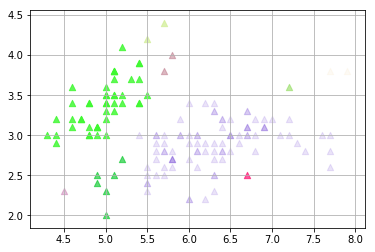

In [88]:
prim = Prim(len(d_m))
prim.graph = d_m
prim.fit(X)
pr_pred = prim.predict(e=0.1)
plot_decisions(X, pr_pred, leg=False)

# FOREL

In [60]:
import numpy as np
import numpy.random as rand


class Forel(object):
    def __init__(self, radius, e=0.01):
        self.radius = radius
        self.e = e
        
    def get_random_center(self, classes):
        # Make sure that the point is not in class already 
        while(True):
            index = rand.randint(0, self.n_obj)
            if classes[index] == 0:
                return self.data[index]
    
    def fit(self, data):
        self.data = np.array(data)
        self.n_obj = len(data)
    
    def change_radius(self, radius):
        if radius > 0:
            self.radius = radius
        
    def euclidean_dist_sq(self, point1, point2):
        assert len(point1) == len(point2)
        result = 0
        for i in range(len(point1)):
            result = result + (point1[i]-point2[i])**2
        return result
    
    def find_mass_center(self, points):
        return points.mean(0)
    
    def transform(self):
        cls = np.zeros(self.n_obj, dtype=np.int)
        class_n = 1
        
        # If all elements have classes, break
        while(not all(el > 0 for el in cls)):
            center = self.get_random_center(cls) 
            while(True):
                class_indx = []
                # Find point that fall into sphere
                for i in range(0, self.n_obj):
                    dist = self.euclidean_dist_sq(center, self.data[i])
                    # Distance between center and point shuld be less than radius
                    # Point shold not belong to any class
                    if dist <= self.radius and cls[i] == 0:
                        class_indx.append(i)
                # Recalculate center
                new_center = self.find_mass_center(self.data[class_indx])
                # If center changed on less than e, append new class labels to the result matrix
                if self.euclidean_dist_sq(center, new_center) < self.e:
                    # Assign class names to elements
                    cls[class_indx] = class_n
                    class_n = class_n + 1
                    break
                else:
                    center = new_center
                    
        # Array of elements
        return cls

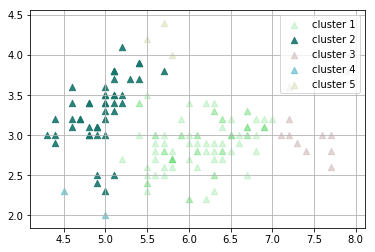

In [93]:
forel = Forel(radius=1)
forel.fit(X)
frl_pred = forel.transform()
plot_decisions(X, frl_pred)

# K-means

In [62]:
class Kmeans(object):
    def fit(self, data):
        self.data = data
       
    def euclidean_dist_sq(self, point1, point2):
        return (point1[0]-point2[0])**2+(point1[1]-point2[1])**2
    
    def predict(self, k, X, n_iter, seed=0):
        x_max, x_min = max(X[:,0]), min(X[:,0])
        y_max, y_min = max(X[:,1]), min(X[:,1])

        np.random.seed(seed)
        centroids = np.random.rand(k,2)

        centroids[:,0] = x_min+(x_max-x_min)*centroids[:,0]
        centroids[:,1] = y_min+(y_max-y_min)*centroids[:,1]

        for i in range(n_iter):
            clusters = []
            for point in X:
                distances = []
                for centr in centroids:
                    distances.append(self.euclidean_dist_sq(point,centr))
                clusters.append(distances.index(min(distances)))
            clusters = np.array(clusters)

            for n in range(k):
                centroids[n,:] = np.mean(X[clusters==n,0]),np.mean(X[clusters==n,1])

        self.plot(X, clusters, centroids)
    
    def plot(self, X, clusters, centroids):
        plt.scatter(X[clusters==0,0],
                   X[clusters==0,1],
                   s=40,
                   c='lightgreen',
                   marker='s',
                   label='cluster 1')
        plt.scatter(X[clusters==1,0],
                   X[clusters==1,1],
                   s=40,
                   c='orange',
                   marker='o',
                   label='cluster 2')
        plt.scatter(X[clusters==2,0],
                   X[clusters==2,1],
                   s=40,
                   c='blue',
                   marker='v',
                   label='cluster 3')
        plt.scatter(X[clusters==3,0],
                   X[clusters==3,1],
                   s=40,
                   c='purple',
                   marker='^',
                   label='cluster 4')
        plt.scatter(centroids[:,0],
                   centroids[:,1],
                   s=150,
                   marker='*',
                   c='red',
                   label='centroids')    
        plt.legend()
        plt.grid()
        plt.show()

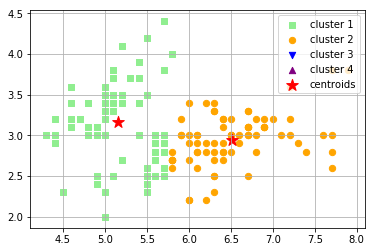

In [95]:
kmeans = Kmeans()
kmeans.fit(X)
km_pred = kmeans.predict(k=2, n_iter=15, X=X, seed=124)

# Metrics

In [64]:
import pandas as pd


hap_df = pd.read_csv('happiness.csv')
data_full = hap_df.as_matrix()
data = data_full[:,3:]
hap_eucl = calculate_dist(data, how='euclid')
hap_mink = calculate_dist(data, how='minkowski')
hap_cab = calculate_dist(data, how='taxicab')
hap_cheb = calculate_dist(data, how='chebyshev')

In [65]:
hap_eucl

array([[  0.00000000e+00,   1.44961119e-01,   2.01928467e-02, ...,
          2.74702148e+01,   2.60974636e+01,   2.69581108e+01],
       [  1.44961119e-01,   0.00000000e+00,   1.79593638e-01, ...,
          2.79269104e+01,   2.59074097e+01,   2.69584064e+01],
       [  2.01928467e-02,   1.79593638e-01,   0.00000000e+00, ...,
          2.67130032e+01,   2.52817211e+01,   2.61724339e+01],
       ..., 
       [  2.74702148e+01,   2.79269104e+01,   2.67130032e+01, ...,
          0.00000000e+00,   3.03075266e+00,   2.21552062e+00],
       [  2.60974636e+01,   2.59074097e+01,   2.52817211e+01, ...,
          3.03075266e+00,   0.00000000e+00,   2.54044861e-01],
       [  2.69581108e+01,   2.69584064e+01,   2.61724339e+01, ...,
          2.21552062e+00,   2.54044861e-01,   0.00000000e+00]], dtype=float32)